<a href="https://colab.research.google.com/github/manabil/Machine_Learning_Intermediate/blob/main/4-%20Time%20Series/4B-%20Time%20Series%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Nama : Muhammad Ammar Nabil<br>
Kelas : M03<br>
email : mammarnabil1@gmail.com

## 1. Preprocessing Data
---

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# Read File
dataset = pd.read_csv('temperature.csv')
dataset.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [ ]:
# Check null value
dataset.isnull().sum()

datetime               0
Vancouver            795
Portland               1
San Francisco        793
Seattle                3
Los Angeles            3
San Diego              1
Las Vegas              1
Phoenix                3
Albuquerque            1
Denver                 1
San Antonio            1
Dallas                 4
Houston                3
Kansas City            1
Minneapolis           13
Saint Louis            1
Chicago                3
Nashville              2
Indianapolis           7
Atlanta                6
Detroit                1
Jacksonville           1
Charlotte              3
Miami                805
Pittsburgh             3
Toronto                1
Philadelphia           3
New York             793
Montreal               3
Boston                 3
Beersheba            798
Tel Aviv District    793
Eilat                792
Haifa                798
Nahariyya            797
Jerusalem            793
dtype: int64

In [ ]:
# Drop Null Value
dataset = dataset.dropna()
dataset.isnull().sum()

datetime             0
Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

In [ ]:
# Drop and Change Type DataFrame
data_train = dataset.drop(dataset.columns.difference(['datetime', 'Boston']), 1)
data_train = data_train.astype(({'Boston': 'float32'}))[3000:20000]
data_train['datetime'] = pd.to_datetime(data_train['datetime'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 3001 to 20030
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  17000 non-null  datetime64[ns]
 1   Boston    17000 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 332.0 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


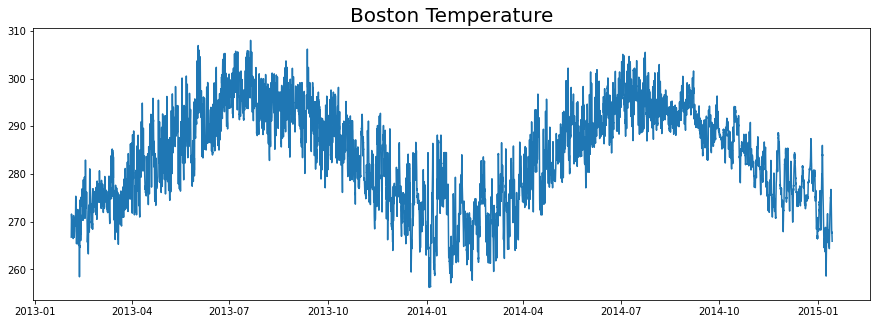

In [ ]:
date = data_train['datetime'].values
temp  = data_train['Boston'].values
    
    
plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.title('Boston Temperature',
            fontsize=20);

## Create Model

In [ ]:
# Normalize Dataset
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(temp.reshape(-1,1))
temp_scaled = temp_scaled.reshape(temp_scaled.size,)
temp_scaled

array([0.20355368, 0.20954084, 0.23252249, ..., 0.2026844 , 0.19181824,
       0.18693829], dtype=float32)

In [ ]:
# Define MAE Threshold < 10%
print(f'min temp : {min(temp_scaled)}\nmax temp : {max(temp_scaled)}')
min_MAE = (max(temp_scaled) - min(temp_scaled)) * 10/100
print(f'\nMinimum MAE is {min_MAE}')

min temp : 0.0
max temp : 1.0

Minimum MAE is 0.1


In [ ]:
# Create Callback MAE < 10%
class MAECallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<min_MAE):
      print("\nMAE < 10% Data Scale")
      self.model.stop_training = True
MAE_callbacks = MAECallback()

In [ ]:
# Create Windowing Function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(date, temp_scaled, test_size = 0.2, shuffle = False )

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(13600,) (3400,)
(13600,) (3400,)


In [ ]:
# Create Model
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=5000)
val_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.SGD(1.0000e-04, 0.9)
model.compile(loss='huber_loss',
                optimizer=optimizer,
                metrics=["mae"])

In [ ]:
history = model.fit(train_set, epochs=200, validation_data = val_set, 
                    callbacks=[MAE_callbacks])

Epoch 1/200
136/136 [==============================] - 25s 127ms/step - loss: 0.0813 - mae: 0.3546 - val_loss: 0.0332 - val_mae: 0.2296
Epoch 2/200
136/136 [==============================] - 12s 79ms/step - loss: 0.0384 - mae: 0.2221 - val_loss: 0.0134 - val_mae: 0.1353
Epoch 3/200
136/136 [==============================] - 9s 64ms/step - loss: 0.0296 - mae: 0.1939 - val_loss: 0.0090 - val_mae: 0.1113
Epoch 4/200
136/136 [==============================] - 9s 64ms/step - loss: 0.0273 - mae: 0.1873 - val_loss: 0.0078 - val_mae: 0.1036
Epoch 5/200
136/136 [==============================] - 10s 65ms/step - loss: 0.0250 - mae: 0.1798 - val_loss: 0.0074 - val_mae: 0.1006
Epoch 6/200
136/136 [==============================] - 11s 72ms/step - loss: 0.0237 - mae: 0.1751 - val_loss: 0.0071 - val_mae: 0.0989
Epoch 7/200
136/136 [==============================] - 10s 65ms/step - loss: 0.0223 - mae: 0.1702 - val_loss: 0.0069 - val_mae: 0.0976
Epoch 8/200
136/136 [==============================] - 1

In [ ]:
# Make plot function
def printPlot(label: list, title: str, legend: list, *args: str):
    '''
    Print plot of history
    * label[0]  = x_label
    * label[1]  = y_label
    * label[n]  = n_label
    * args[n]   = line_n
    * legend[n]  = [location, line_n, ...]
    '''
    plt.style.use('dark_background')

    plt.title(title)
    plt.plot(history.history[args[0]], '#1f77b4')
    plt.plot(history.history[args[1]], '#ff7f0e')
    plt.xlabel(label[0])
    plt.ylabel(label[1])
    plt.legend(legend[1:], loc=legend[0])
    plt.show()

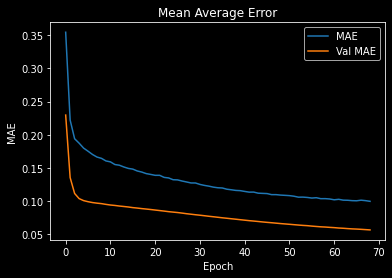

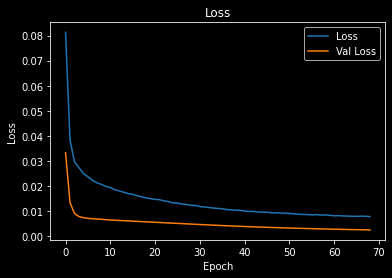

In [ ]:
# Print Plot
printPlot(['Epoch', 'MAE'], 'Mean Average Error', 
          ['upper right', 'MAE', 'Val MAE'],
          'mae', 'val_mae')
printPlot(['Epoch', 'Loss'], 'Loss', 
          ['upper right', 'Loss', 'Val Loss'],
          'loss', 'val_loss')